In [1]:
#!/usr/bin/python
# updated DBR 11/2023 #

%matplotlib inline

import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import resource; resource.setrlimit(resource.RLIMIT_NOFILE, (1000,-1)) #allow many plots

import os

sns.set_style("ticks")

import warnings
warnings.filterwarnings(action='once')


In [2]:
#first do the experiment on those without TN

PWH_ppts = ['PWH22','PWH548','PWH746','PWH583',]
ctl_ppts = ['MACS14173','MACS10136','MACS13042','WIHS',]

PWH_cz=['salmon','peru','tab:red','maroon',]#,'firebrick']
ctl_cz=['lightblue','teal','tab:blue','navy']#,'turquoise']


In [3]:
dfall=pd.read_csv('ecometrics_wprovirusrecalc.csv') #restricted to persistent clonotypes
dfall.columns

Index(['Unnamed: 0', 'pid', 'Age', 'Male', 'CMVstatus', 'mo_post_ART',
       'study_months', 'CD4', 'Nadir CD4', 'mo_pre_ART', 'race', 'cohort',
       'cohort_num', 'HIVstatus', 'initial_N', 'resample_size_TCR',
       'resample_size_HIV', 'color', 'nonsingleton_R', 'R', 'D1', 'D2', 'cmax',
       'c10', 'cfrac', 'RH', 'D1H', 'D2H', 'cmaxH', 'c10H', 'cfracH', 'RMS1',
       'al', 'RMS2', 'alpha1', 'alpha2', 'phi', 'cp', 'nonsingleton_Rr', 'Rr',
       'D1r', 'D2r', 'cmaxr', 'c10r', 'cfracr', 'RHr', 'D1Hr', 'D2Hr',
       'cmaxHr', 'c10Hr', 'cfracHr', 'RMS1r', 'alr', 'RMS2r', 'alpha1r',
       'alpha2r', 'phir', 'NHIV', 'nonsingleton_RHIV', 'RHIV', 'D1HIV',
       'D2HIV', 'cmaxHIV', 'c10HIV', 'cfracHIV', 'RMS1HIV', 'alHIV', 'RMS2HIV',
       'alpha1HIV', 'alpha2HIV', 'phiHIV', 'alHIVsample'],
      dtype='object')

In [4]:
nbs=10 #number of boostraps per ppt

#loop over participants
bigl=[]
for pid in ctl_ppts:
    #pick a ppt
    #pid = 'MACS14173'
    df0 = pd.read_csv('cleanTCRdata/'+pid+'_t0.csv') #note this hasn't been downsampled yet

    N=sum(df0['templates'])
    cHIV = np.round(N*(800+3000)*1e-6) #cells with all HIV

    df0['pa0']=df0['templates']/N #add proportional abundances

    #now loop and bootstrap
    Dtotl=[]
    for bs in range(nbs):
        #get a random sample of their TCR from t0
        #first assume that clonotypes are completely filled
        c=0
        HIVdf=pd.DataFrame()
        while c<cHIV*1.1: #with a little wiggle room
            iTCR = np.random.randint(len(df0))
            HIVdf=HIVdf.append(df0.iloc[iTCR])
            c += df0['templates'].iloc[iTCR]

        print(pid,bs,c)
        #now look for these TCRb in the later time point files

        df1 = pd.read_csv('TM+TN/'+pid+'_t1.tsv',sep='\t',
                          usecols=['extended_rearrangement','cdr3_amino_acid','templates','frame_type'],low_memory=False).dropna()
        df1=df1[df1['frame_type']=='In'] #restrict to only in frame rearrangements
        df1['pa1']=df1['templates']/np.sum(df1['templates']) #add column for proportional abundances

        df2 = pd.read_csv('TM+TN/'+pid+'_t2.tsv',sep='\t',
                          usecols=['extended_rearrangement','cdr3_amino_acid','templates','frame_type'],low_memory=False).dropna()
        df2=df2[df2['frame_type']=='In'] #restrict to only in frame rearrangements
        df2['pa2']=df2['templates']/np.sum(df2['templates']) #add column for proportional abundances

        #merge together "left" meaning keep all the TCRb from t0 and then make zeros if not found again

        df01 = pd.merge(HIVdf, df1, how='left', on=['extended_rearrangement'])
        df012 = pd.merge(df01, df2, how='left', on=['extended_rearrangement'])
        df012 = df012.rename(columns={'templates_x': 'counts_t0', 'templates_y': 'counts_t1', 'templates': 'counts_t2'})
        df012 = df012[['extended_rearrangement','counts_t0','counts_t1','counts_t2','pa0','pa1','pa2']].fillna(0)
    
        Dtot=df012[['pa1','pa2']].sum().values
        #Dtot=all_df[['counts_t1','counts_t2']].sum().values
        Dtotl.append(Dtot)

    bigl.append(Dtotl)

MACS14173 0 1428
MACS14173 1 1457
MACS14173 2 1428
MACS14173 3 1426
MACS14173 4 1426
MACS14173 5 1426
MACS14173 6 1426
MACS14173 7 1434
MACS14173 8 1427
MACS14173 9 1426
MACS10136 0 315
MACS10136 1 315
MACS10136 2 315
MACS10136 3 315
MACS10136 4 315
MACS10136 5 315
MACS10136 6 315
MACS10136 7 315
MACS10136 8 318
MACS10136 9 315
MACS13042 0 1527
MACS13042 1 1488
MACS13042 2 1492
MACS13042 3 1490
MACS13042 4 1488
MACS13042 5 1520
MACS13042 6 1494
MACS13042 7 1488
MACS13042 8 1489
MACS13042 9 1488
WIHS 0 789
WIHS 1 758
WIHS 2 758
WIHS 3 758
WIHS 4 758
WIHS 5 758
WIHS 6 759
WIHS 7 758
WIHS 8 759
WIHS 9 758


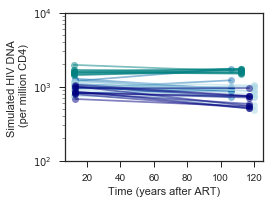

In [7]:
#get mean and std half-lives (or decay rates)
plt.figure(figsize=(4,3))

mhl=[]; shl=[]
mr=[]; sr=[]
for ip,pid in enumerate(ctl_ppts):

    #note true time points
    t1=dfall[dfall['pid']==pid+'_t1']['study_months'].values
    t2=dfall[dfall['pid']==pid+'_t2']['study_months'].values

    cz=dfall[dfall['pid']==pid+'_t1']['color'].iloc[0]
    
    for bs in range(nbs):
        plt.semilogy([t1,t2],bigl[ip][bs]*1e6,marker='o',color=cz,alpha=0.5)
    
    dr=(np.log(np.array(bigl[ip])[:,1]/np.array(bigl[ip])[:,0])/(t2-t1)) #decay rate
    hl=-np.log(2)/(np.log(np.array(bigl[ip])[:,1]/np.array(bigl[ip])[:,0])/(t2-t1))

    mhl.append(np.mean(hl))
    shl.append(np.std(hl))
    
    mr.append(np.mean(dr))
    sr.append(np.std(dr))
    
plt.ylim(100,1e4)
plt.xlabel('Time (years after ART)')
plt.ylabel('Simulated HIV DNA \n (per million CD4)')
plt.tight_layout()
plt.savefig('figures/simIPDA-traces.pdf')


In [9]:
#data for summary
inthl=-np.log(2)/np.array([32,18,141])
defhl=-np.log(2)/np.array([161,28,1000])

#PWHm=np.mean(mr)
#PWHs=np.mean(sr)

Ctlm=np.mean(mr)
Ctls=np.mean(sr)


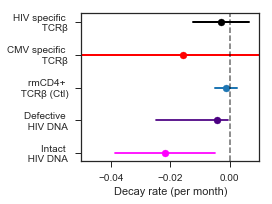

In [16]:
#plot results of rate changes vs IPDA decay and virus specific
    
plt.figure(figsize=(4,3))

#intact
plt.scatter(inthl[0],1,color='magenta')
plt.plot([inthl[1],inthl[2]],[1,1],c='magenta')

#defective
plt.scatter(defhl[0],2,color='indigo')
plt.plot([defhl[1],defhl[2]],[2,2],c='indigo')

#PWH TCR decays
#plt.scatter(PWHm,3,color='maroon',marker='o')
#plt.plot([PWHm-2*PWHs,PWHm+2*PWHs],[3,3],color='tab:red',lw=2)

#Ctl TCR decays
plt.scatter(Ctlm,3,color='tab:blue',marker='o')
plt.plot([Ctlm-2*Ctls,Ctlm+2*Ctls],[3,3],color='tab:blue',lw=2)

CMVm=-0.015630371732489677
CMVs= 0.027149217208730498
HIVm=-0.0030301935182166476
HIVs=0.004686757616797171

#CMV specific TCR decays
plt.scatter(CMVm,4,color='red',marker='o')
plt.plot([CMVm-2*CMVs,CMVm+2*CMVs],[4,4],color='red',lw=2)

#HIV specific TCR decays
plt.scatter(HIVm,5,color='k',marker='o')
plt.plot([HIVm-2*HIVs,HIVm+2*HIVs],[5,5],color='k',lw=2)

plt.xlabel('Decay rate (per month)')
plt.axvline(0,color='k',ls='--',alpha=0.5)
#plt.axvline(2.5,color='gray',alpha=0.3)

#plt.yticks(np.arange(4)+1,['Intact \n HIV DNA','Defective \n HIV DNA',
#                           'rmCD4+ \n TCR \n (PWH)','rmCD4+ \n TCR \n (Ctl)'],rotation=0)

plt.yticks(np.arange(5)+1,['Intact \n HIV DNA','Defective \n HIV DNA',
                           'rmCD4+ \n TCRβ (Ctl)',
                          'CMV specific \n TCRβ','HIV specific \n TCRβ'],rotation=0)


#plt.ylim([0.5,4.5])
plt.xlim([-0.05,0.01])

plt.tight_layout()    
plt.savefig('figures/simIPDA-summary.pdf',dpi=600)



In [22]:
#stats on whether intact and defective from TCR
print(st.norm.pdf((inthl[2]-Ctlm)/Ctls),st.norm.pdf((defhl[2]-Ctlm)/Ctls))

0.0665443592288306 0.3738558970461561


In [ ]:
#get sd from lower 95%
#int=m-2*sd
#(m-int)/2

In [19]:
#stats on whether TCR from intact
sdl=(inthl[0]-inthl[1])/1.96
sdu=(inthl[0]-inthl[2])/1.96

print(
    st.norm.pdf((Ctlm-inthl[0])/sdl),
    st.norm.pdf((Ctlm-inthl[0])/sdu))

0.024586428800553395 0.023759994264977474


In [20]:
#stats on whether TCR from defective
sdl=(defhl[0]-defhl[1])/1.96
sdu=(defhl[0]-defhl[2])/1.96

print(
    st.norm.pdf((Ctlm-defhl[0])/sdl),
    st.norm.pdf((Ctlm-defhl[0])/sdu))

0.3834496714547429 0.11208589070007112


In [ ]:
PWHm